# BME 590 - Workshop 2 - Liquid Handling
**Professor:** Emma Chory, Ph.D.

**Authors:**
Rick Wierenga, Joe Laforet, Stefan Golas, Ben Perry

---

### Usage Note
**Reminder** - You should be running this notebook **remotely** on **Google Colab** not navigating it through **GitHub**.

**Reminder 2** - Remember to run `git pull` before copying this notebook so you get the most recent class updates. See [Section 6 of the class README](https://github.com/chory-lab/bme590-fall-2025#step-6-updating-to-the-latest-version)

---

#### Colab Specific Install

Similar to **workshop 1** we are gonig to have to re-install the specialized version of PLR

In [ ]:
%%capture
!git clone https://github.com/benjamin-perry-duke/pylabrobot.git && cd pylabrobot && pip install -e ".[dev]" && pip install opentrons

Remmember to **Runtime -> Restart Session** BEFORE proceeding

In [ ]:
import pylabrobot.pylabrobot as pylabrobot
import opentrons
import asyncio # colab specific
# colab specific state tracker
active_instances = {
    "lh": None,
    "vis": None
}

## Liquid Handling Basics
Now that you have gotten an introduction to setting up a deck in PyLabRobot, this second lesson is going to cover everything liquids! From setting their inintial levels to moving them around to managing tips and cross-contamination!


### Adding Liquids to Lab Objects
Usually when you start an automated protocol, you will have reservoirs of liquid somewhere on the deck. In fancier setups, this liquid can be moved to the deck from a pump system or a robotic arm carrying a reservoir from temperature control. For these exercises we will assume the liquid was placed manually by the user (such as manual preparation of reagents or usage of a kit, as is common in many experiments)

Therefore, to begin, we will need to **set the state** of liquids in a starting set of wells or a reservoir.

To start, let's go ahead and set up a basic HamiltonSTAR deck with:

- 1 reservoir

- 1 12 tube rack

- 2 96 well plates

- 1 384 well plate

- 1 1000 uL tip rack

- 1 300 uL tip rack

- 1 10 uL tip rack

We will start with a function that will set up this deck for us. Run the code below and you should get a deck that looks like this!

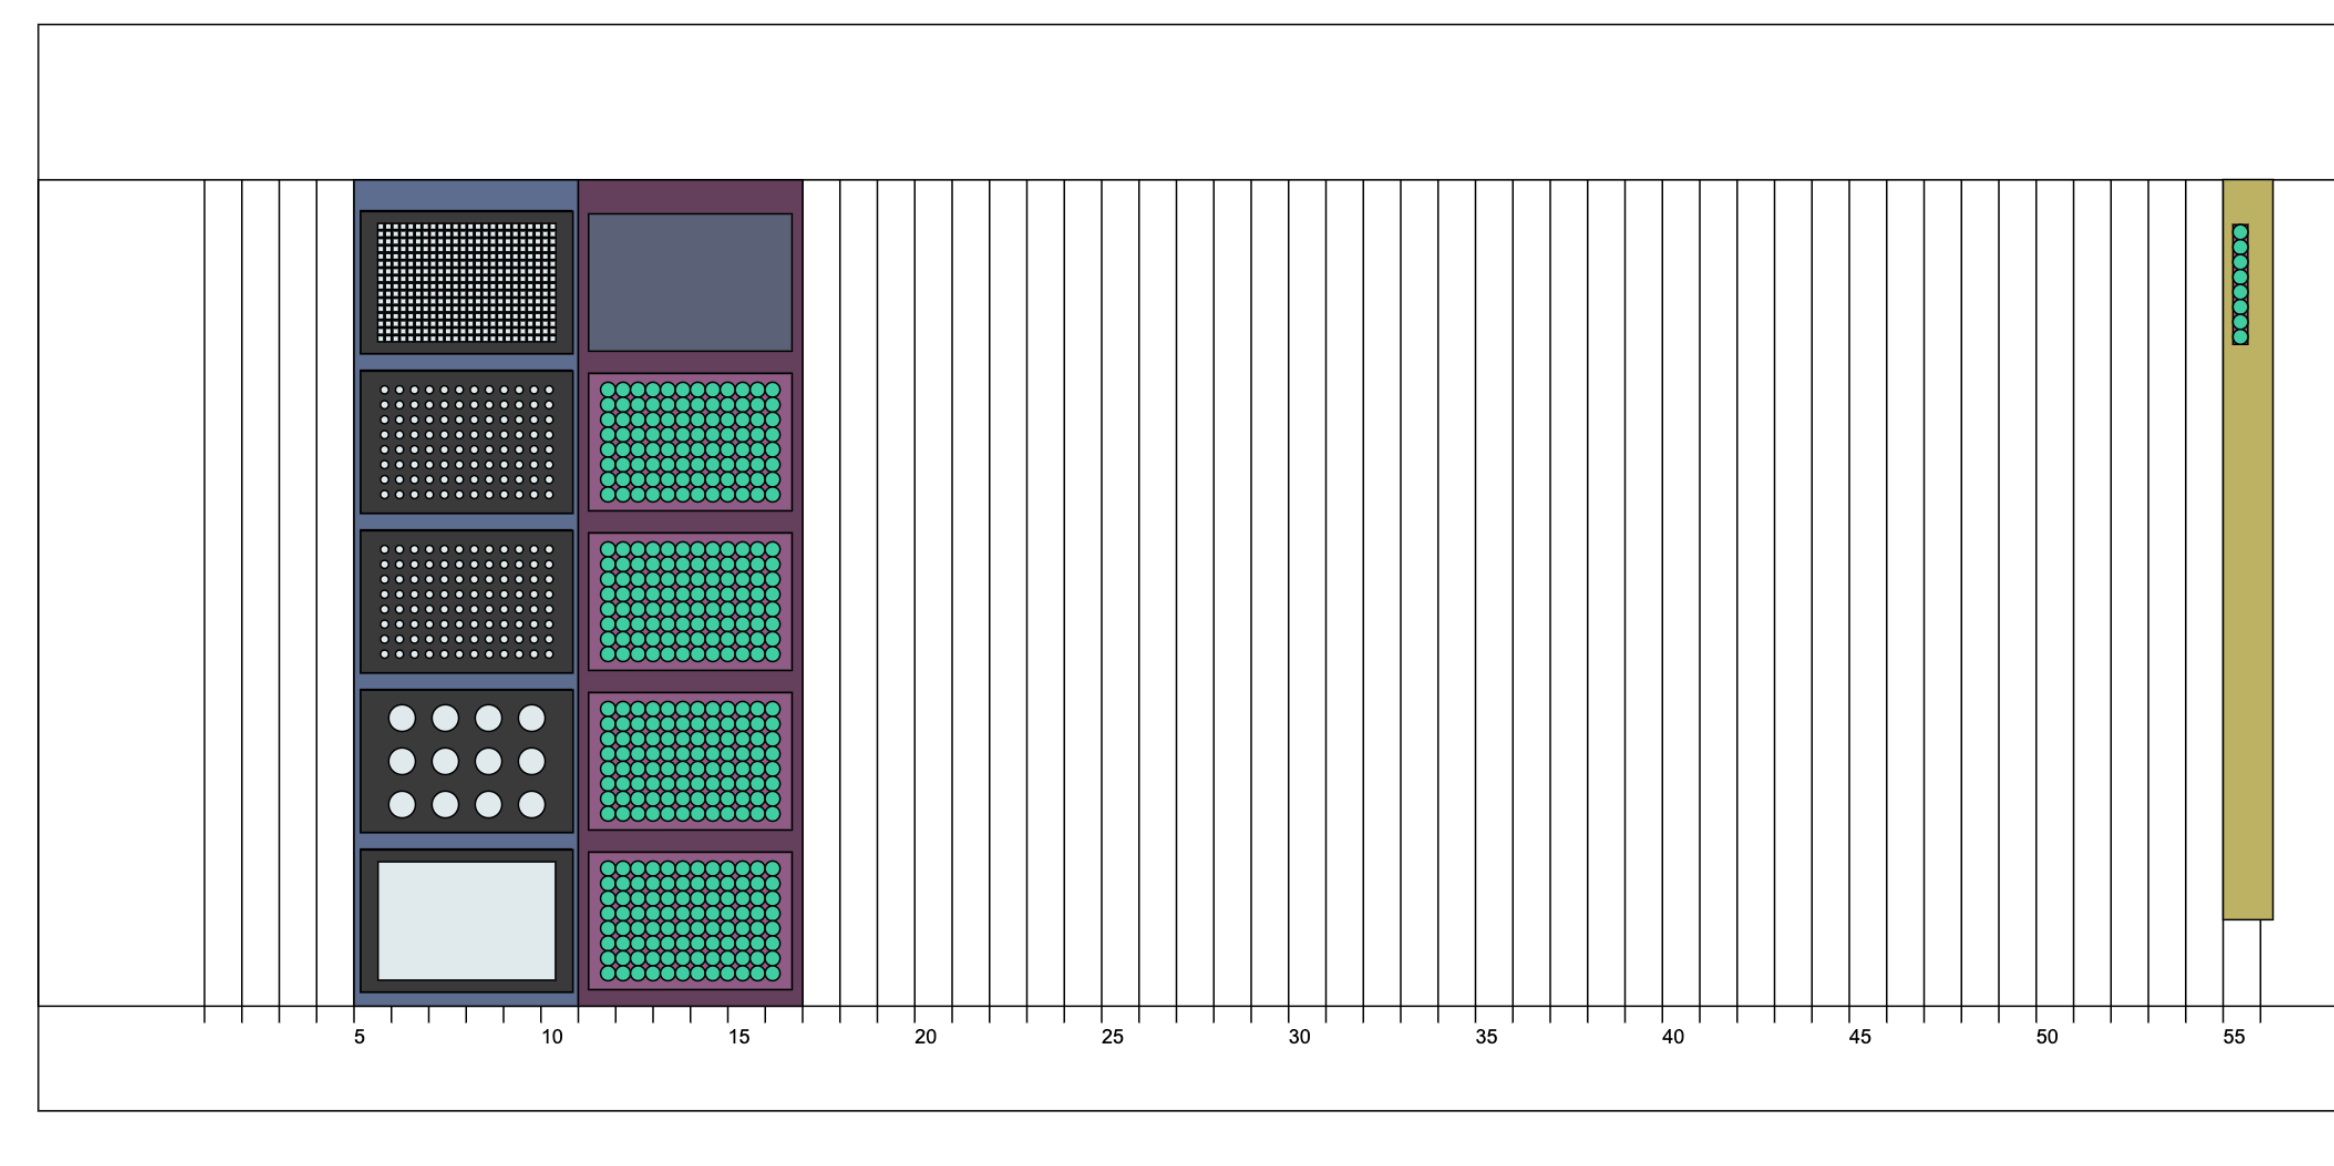

First, let's import the relevant resources

In [ ]:
from pylabrobot.resources import Deck
from pylabrobot.liquid_handling.backends.backend import LiquidHandlerBackend
from pylabrobot.liquid_handling import LiquidHandler
from pylabrobot.liquid_handling.backends import LiquidHandlerChatterboxBackend
from pylabrobot.resources.hamilton import STARDeck
from pylabrobot.visualizer.visualizer import Visualizer

from pylabrobot.resources import (
    set_tip_tracking,
    set_volume_tracking,
    TIP_CAR_480_A00,
    PLT_CAR_L5AC_A00,
    corning_96_wellplate_360ul_flat,
    corning_384_wellplate_112ul_flat,
    nest_1_reservoir_195ml,
    corning_12_wellplate_6point9ml_flat,
    HTF,
    LTF,
    STF
)

We will also now enable tip and volume tracking so thte code will **throw errors** if something goes wrong.

In [ ]:
# enable tracking of tip status and volumes
set_volume_tracking(enabled=True)
set_tip_tracking(enabled=True)

Let's go ahead and define a function to visualize the deck and also set up the deck.

In [ ]:
async def visualize_deck_colab(deck: Deck,
                         backend: LiquidHandlerBackend):

    # shut down old instances, if active
    if active_instances["vis"] is not None:
        print("stopping previous visualizer...")
        await active_instances["vis"].stop()
    if active_instances["lh"] is not None:
        print("stopping previous liquid handler...")
        await active_instances["lh"].stop()
        await asyncio.sleep(1)

    # create new lh and vis
    try:
        print("\nsetting up new liquid handler and visualizer...")
        lh = LiquidHandler(backend=backend, deck=deck)
        vis = Visualizer(resource=lh)
        await lh.setup()
        await vis.setup()

        # store states
        active_instances["lh"] = lh
        active_instances["vis"] = vis

        return lh, vis

    except Exception as e:
        print(f"An error occurred: {e}")
        active_instances["lh"] = None
        active_instances["vis"] = None
        return None, None

async def make_liquid_handling_deck():
    deck = STARDeck()
    tip_carrier = TIP_CAR_480_A00(name="awesome tip carrier 96x5")
    plate_carrier = PLT_CAR_L5AC_A00(name = "awesome plate carrier")
    tip_rack_names = [
        "1000_tips_0",
        "1000_tips_1",
        "300_tips_0",
        "300_tips_1",
        "10_tips_0"
    ]
    tip_rack_instantiators = [
        HTF,
        HTF,
        STF,
        STF,
        LTF
    ]
    plate_names = [
        "reservoir_0",
        "12_plate_0",
        "96_plate_0",
        "96_plate_1",
        "384_plate_0"
    ]
    plate_instantiators = [
        nest_1_reservoir_195ml,
        corning_12_wellplate_6point9ml_flat,
        corning_96_wellplate_360ul_flat,
        corning_96_wellplate_360ul_flat,
        corning_384_wellplate_112ul_flat
    ]
    for i, (name, tip_rack) in enumerate(zip(tip_rack_names, tip_rack_instantiators)):
        tip_carrier[i] = tip_rack(name = name)
    for i, (name, plate) in enumerate(zip(plate_names, plate_instantiators)):
        plate_carrier[i] = plate(name = name)

    deck.assign_child_resource(plate_carrier, rails = 5)
    deck.assign_child_resource(tip_carrier, rails = 11)
    return deck

Call the functions to set up the deck

In [ ]:
deck = await make_liquid_handling_deck()
lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

Let's print a summary of our deck so far.

In [ ]:
print(lh.deck.summary())

#### Setting Liquid Volumes
In order to manually set liquid volumes, there are a couple of methods we can use. Since we are going to be adding liquids to the plates/reservoirs, let's go ahead and get the 12-well and 96-well plate using `get_resource` with their names.

In [ ]:
plate_96 = lh.deck.get_resource("96_plate_0")
plate_12 = lh.deck.get_resource("12_plate_0")

The easiest way we can fill a specific level of liquid in a specific well is to access it by index.

Remember that a plate has wells as it's children, and we can access these by identifier using the `get_well` method. This method expects an identifier, which can be either an index (0 - 95) representing the well index, or it can be the actual letter-integer coordinate of the well (e.g. A1, B2, etc.)

We show both indexing methods below

In [ ]:
well_1 = plate_96.get_well(0)
well_2 = plate_96.get_well("A1")
well_3 = plate_96.get_item("A1")
well_4 = plate_96.get_item(0)

print(well_1 == well_2 == well_3 == well_4) # this should evaluate to True, meaning these are all equivalent methods.

To fill this well with liquid, we need to access its `tracker` attribute and specifically use the `set_liquids` method. This method expects a **tuple**, where the first index is the name or class of liquid and the second index is the volume, in uL, for example:
- **(None, 180)** - Unknown liquid - 180 uL volume
- **("Red Dye", 2000)** - Custom liquid named "Red Dye" - 2000 uL volume
- **(Liquid.OCTANOL, 360)** - Official PLR Liquid class for Octanol - 360 uL volume.

Let's go ahead and demonstrate some of these below

First import the Liquid class.

In [ ]:
from pylabrobot.resources import Liquid # import for liquid class

Then define the liquids as tuples

In [ ]:
# get wells of interest
unknown_liquid = (None, 180)
red_dye = ("Red Dye", 2000)
octanol = (Liquid.OCTANOL, 360)

Now assign the liquids to the relevant plates

In [ ]:
plate_96.get_well("A1").tracker.set_liquids([unknown_liquid])
plate_96.get_well("B1").tracker.set_liquids([octanol])
plate_12.get_well("A1").tracker.set_liquids([red_dye])

Great! Now go look at the visualizer. You should see something like this:

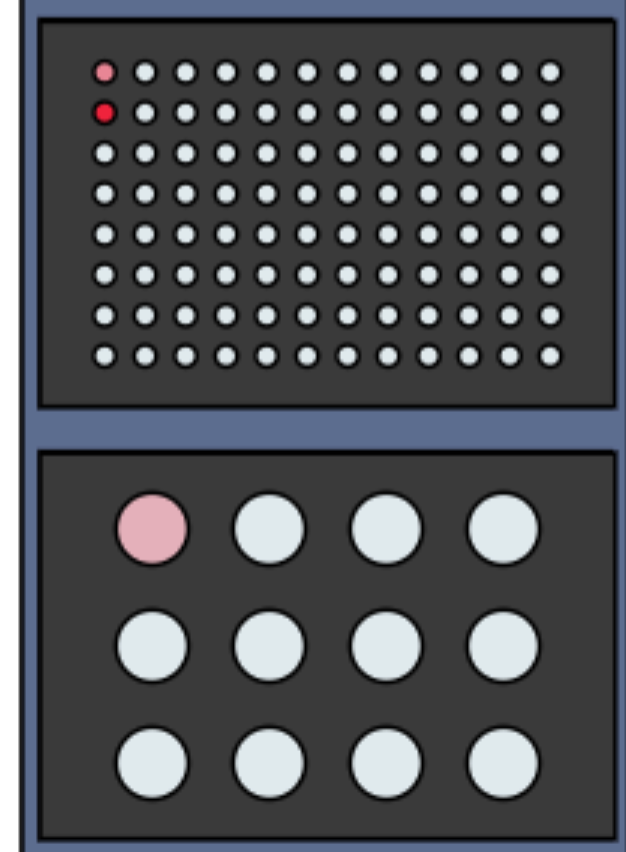

The visualizer will actually shade the liquid volume by the amount in a well, relative to that well's maximum volume! So you can see, well B1 is filled to capacity (360 uL / 360 uL), so it has the deepest red color, while well A1 only has 180 uL, so it is filled to half capacity. Finally, well A1 of the 12-well plate is filled the least (percentage-wise) so it has the lightest color.

Currently, only red is supported as the color of solvent, so you'll haave to use your imagination here if mixing liquids. We can also use the `add_liquid` and `remove_liquid` functions to achieve similar functionality as the `set_liquids` function. These should **not** be used in lieu of pipetting operations, but rather are meant to be used to represent manual operations outside the liquid handler.

**Note-** The `add_liquid` function expects the liquid identifier as the first argument and the amount as the second argument, so just unpack the tuple. The `remove_liquid` doesn't require a liquid identifier, just the amount ot remove. The `remove_liquid` function will lso return a List of Tuples of liquids and volume removed if you call the function, which may be useful to store as a variable, for example, if you have to manually move an entire well contents somewhere else manually during a protocol.

In [ ]:
plate_96.get_well("A1").tracker.add_liquid(*unknown_liquid)
plate_12.get_well("A1").tracker.remove_liquid(volume = 2000)

Great! You should now have something that looks like this

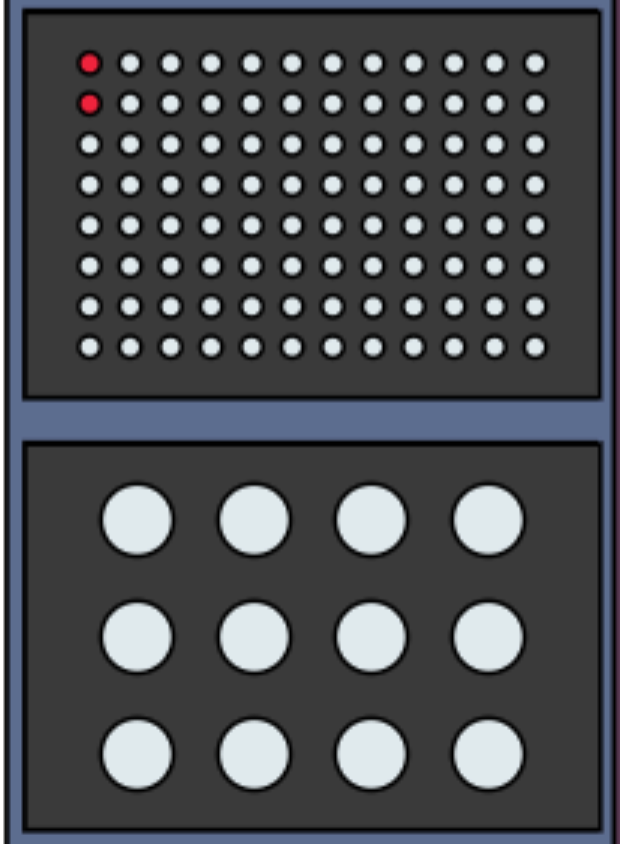

Note, since we doubled the liquid in well A1, it is now also full! We have also removed all the liquids in well A1 of the 12-well plate.

Certainly, you could manually assign liquids to each well, but this would get cumbersome with a lot of wells you are trying to fill!

There are several options for traversing over wells using iterators. Let's see some examples below

#### Traversal of Labware
There are several ways to iterate over a given piece of labware, including **manual loops** and **traversal functions**. This section will review both methods; you should implement the one you are most comfortable with using in the Python code (i.e. there is not a definite solution on how to traverse over labware but we are outlining several options)

##### Manual Looping
Since we know how many wells are preseent on a given piece of labware, we can utilize that information to manually loop through all spots on a given plate using a **for loop** in Python and the `get_well()` method.


First we are going to make a helper function to reset the liquids on a given plate.

In [ ]:
# define function to reset liquids on a plate
def reset_liquids(plate, plate_num_items: int = 96):
    liquids = [[(None, 0)]] * plate_num_items
    plate.set_well_liquids(liquids)

Let's go ahead and reset the entire deck and get the relevant plates again.

In [ ]:
# reset deck
deck = await make_liquid_handling_deck()
lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

# get the plates of interest
plate_96_0 = lh.deck.get_resource("96_plate_0")
plate_96_1 = lh.deck.get_resource("96_plate_1")
plate_12 = lh.deck.get_resource("12_plate_0")

Let's add 150 uL to every well on the first 96 well plate

In [ ]:
for i in range(96):
    plate_96_0.get_well(i).tracker.set_liquids([red_dye])

Now let's add 150 uL but only to **every other column** in the second 96 well plate

In [ ]:
for i in range(96):
    if i % 16 <= 7: # modulo operator get's the remainder of each item
        plate_96_1.get_well(i).tracker.set_liquids([red_dye])

Great! You should see something like this!

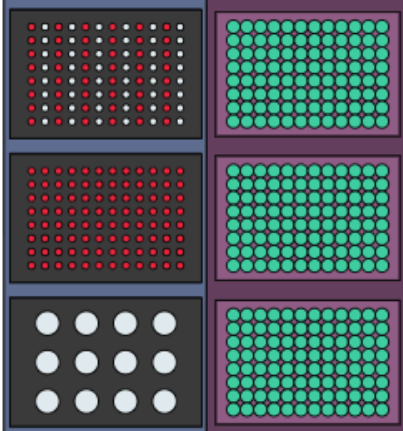

We can also index by the **letter-integer combination**.

Let's fill in the **second and fourth row** of the second plate.

In python, an f-string is denoted by `f"<str_contents>"` where you can fill in variables inside the quotes with their value. for example `print(f"Number: {i}")` will print "Number 1, Number 2..."

In [ ]:
# 2nd row is B1 - B12
# 4th row is D1 - D12
reset_liquids(plate_96_1)
for i in range(12):
    plate_96_1.get_well(f"B{i + 1}").tracker.set_liquids([red_dye])
    plate_96_1.get_well(f"D{i + 1}").tracker.set_liquids([red_dye])

Great! You should see something like this!

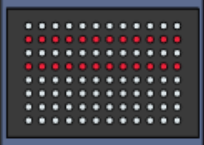

Now let's fill in the **second and fourth columns** of the second plate.

We can do this by defining a capital letter alphabet that ranges from A - H

In [ ]:
# 2nd column is A2 - H2
# 4th column is A4 - H4
reset_liquids(plate_96_1)
alphabet = [chr(i) for i in range(65, 73)]
print(f"{alphabet=}") # prints alphabet=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

for i in range(8):
    plate_96_1.get_well(f"{alphabet[i]}2").tracker.set_liquids([red_dye])
    plate_96_1.get_well(f"{alphabet[i]}4").tracker.set_liquids([red_dye])

Great! You should see something like this!

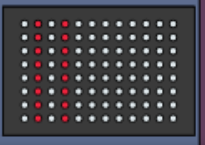

Yet another way to index into a plate is to actually check **how many items, rows, or columns** it has via the `num_items` property

In [ ]:
# if you don't know the number of items in a given plate, you can check
print(f"X-axis items (96 well plate): {plate_96_1.num_items_x}")
print(f"Y-axis items (96 well plate): {plate_96_1.num_items_y}")
print(f"All items (96 well plate): {plate_96_1.num_items}")

We can also do this for the 12-well plate as well.

In [ ]:
print(f"X-axis items (12 well plate): {plate_12.num_items_x}")
print(f"Y-axis items (12 well plate): {plate_12.num_items_y}")
print(f"All items (12 well plate): {plate_12.num_items}")

We can also use this method to fill in **every other row** on a given plate, which may be more intuitive to use.

Generally though, you should know the **number of items** in a given plate for your protocol, rather than relying on PLR to tell you.

In [ ]:
reset_liquids(plate_96_1)

# get the number of rows and cols
num_rows = plate_96_1.num_items_y
num_cols = plate_96_1.num_items_x

# for each row, if it is an even numbered row, fill it
for row in range(num_rows):
    if row % 2 == 0:
        for well in plate_96_1.row(row):
            well.tracker.set_liquids([red_dye])

Great! You should see something like this!

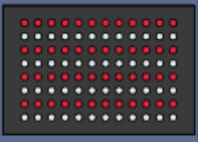

#### Traversal Functions
To iterate over locations on labware, we can also use the `traverse()` function. This produces a [generator](https://wiki.python.org/moin/Generators) object that we can iterate over to yield our desired wells.

`traverse()` takes in three arguments:

* **batch_size** is the amount of wells to return

* **start** is where to start

* **direction** is how to iterate over the wells.

**More info on direction:**

- starting location can be one of "top_left", "bottom_left", "top_right", "bottom_right"

- direction can be one of "up", "down", "right", "left", "snake_up", "snake_down","snake_left", "snake_right",

The snake directions alternate between going in the given direction and going in the opposite direction. For example, "snake_down" will go from **A1** to **H1**, then **H2** to **A2**, then **A3** to **H3**, etc.

The **benefit** of using the `traverse()` function over a simple manual iteration is it can enable complex traversals while **maintaining minimal clean code**.

We recommend running the function below to experiment with different iterator settings.

The iterator will also throw an **error** if an illegal setup is defined. For example, try setting:

- `start="bottom_right"`
- `direction="down"`

You should get an **error** like this:

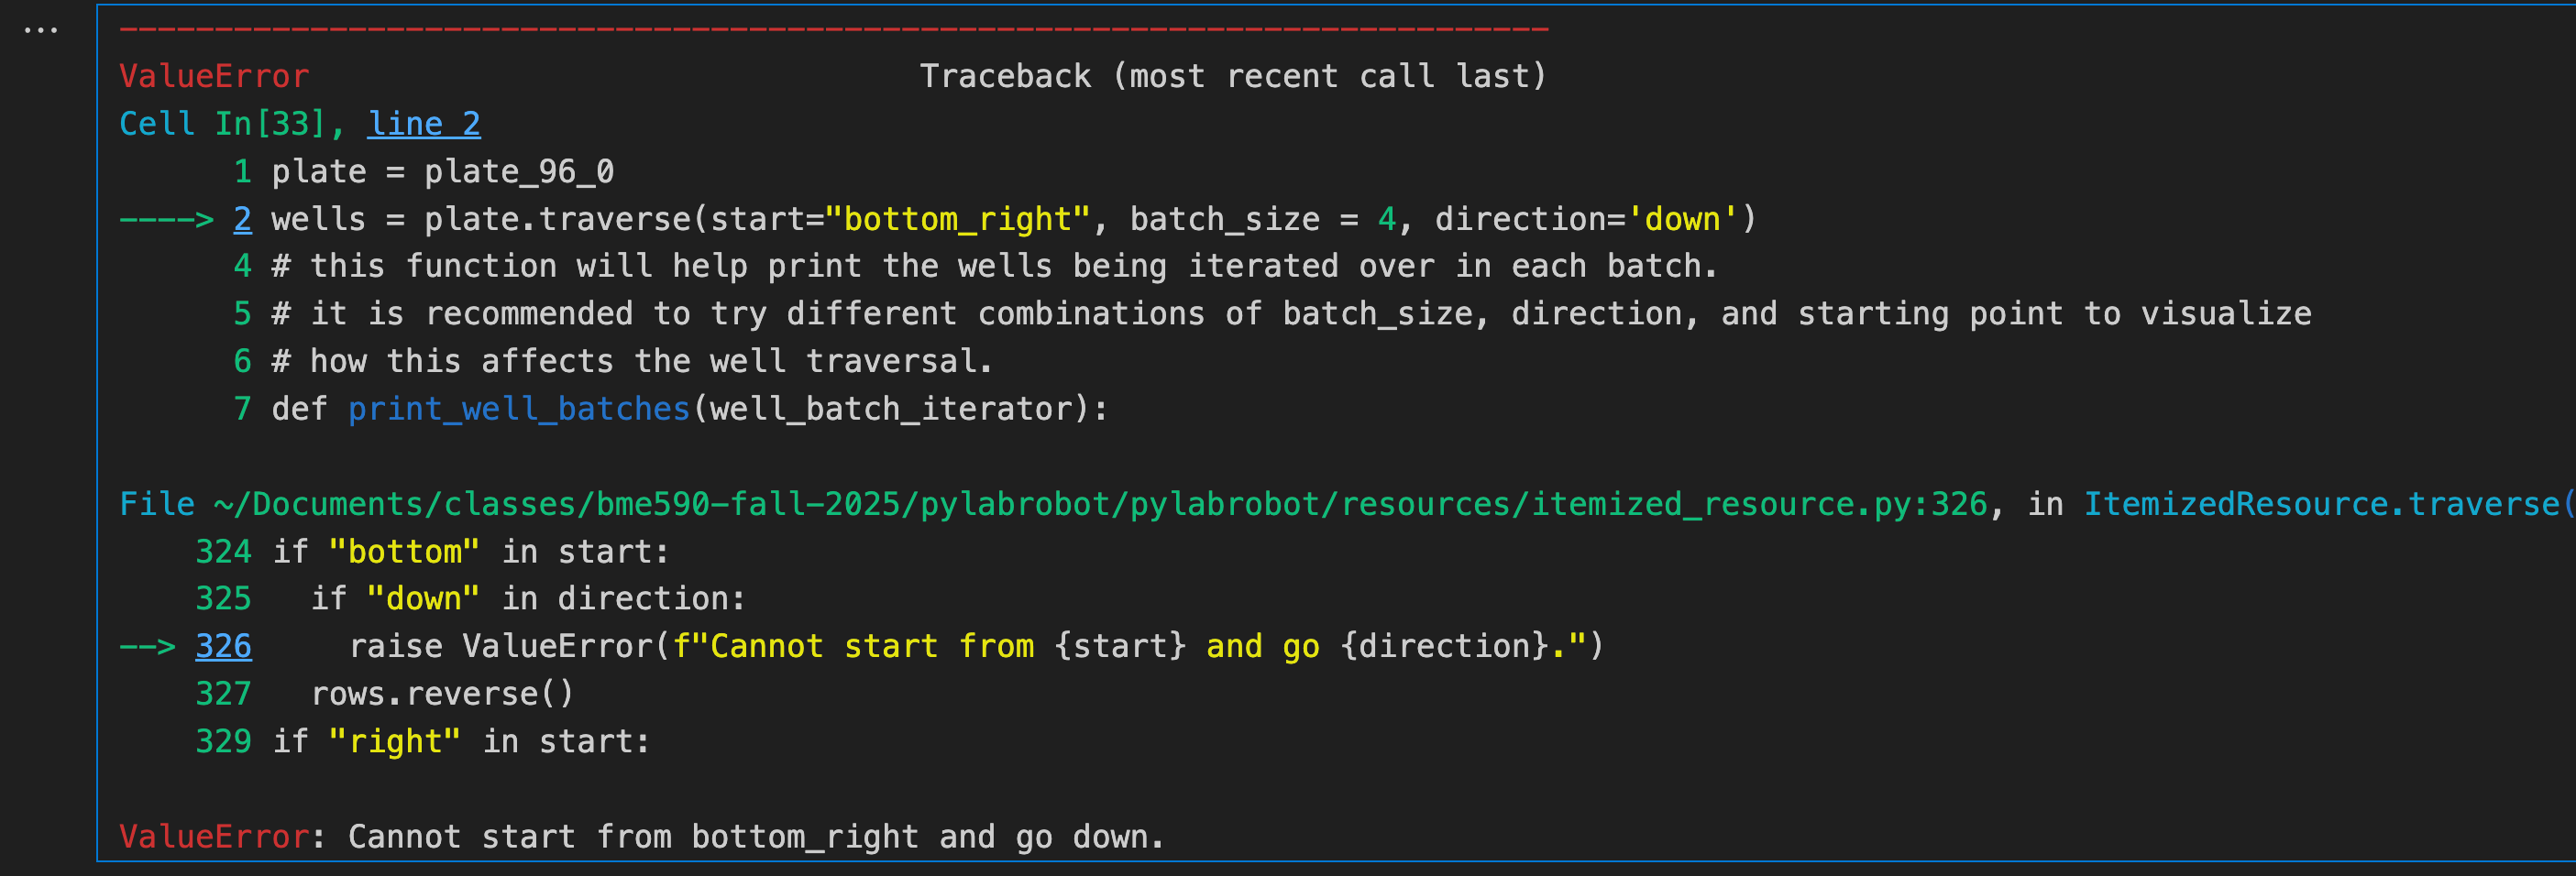

In [ ]:
plate = plate_96_0

# EXPERIMENT HERE - CHANGE THESE SETTINGS AND SEE WHAT HAPPENS
wells = plate.traverse(start="top_left", batch_size = 4, direction='down')

# this function will help print the wells being iterated over in each batch.
# it is recommended to try different combinations of batch_size, direction, and starting point to visualize
# how this affects the well traversal.
def print_well_batches(well_batch_iterator):
    for i, well_batch in enumerate(well_batch_iterator):
        start_well = well_batch[0].name.split("_")[-1]
        end_well = well_batch[-1].name.split("_")[-1]
        print(f"Batch {i}:\tStart Well: {start_well}\tEnd Well: {end_well}")

print_well_batches(wells)

To further help you **visualize** the effect of different settings on the `traverse()` function, the following helper script will **fill every other batch** provided by the `traverse()` function.

Please explore different combinations of parameters in the `traverse()` function to visualize how you can iterate over wells in a plate.

In [ ]:
plate = plate_96_0

# EXPERIMENT HERE - CHANGE THESE SETTINGS AND SEE WHAT HAPPENS
wells = plate.traverse(start="top_left", batch_size = 3, direction='down')

# this function will enable trying differnet traversal methods and filling every other batch with
# red liquid on the visualizer to see how the traversal method changes things
def fill_every_other_batch(well_batch_iterator, plate):
    reset_liquids(plate)
    for i, well_batch in enumerate(well_batch_iterator):
        if i % 2 == 0:
            for well in well_batch:
                well.tracker.set_liquids([red_dye])
fill_every_other_batch(wells, plate)

### Tip racks
Tip racks are similar to a plate with wells or any other iterable resource; however, instead of caring about **what liquids** and **how much** are in each well, we now simply ask the question whether or not a **tip spot** contains an **unused tip**.

Generally, most liquid handlind movements will necessarily have the following steps at some point:

1. Pick up $N$ unused tips (or alternatively, re-use tips if they will not lead to cross-contamination...more on this later).

2. Aspirate $V$ volume of liquid into the $N$ channels holding $N$ tips.

3. Move pipetting head to a separate plate or target destination.

4. Dispense $V$ volume of liquid into $N$ target wells with $N$ channels.

5. Discard or return the used tips

Let's examine our tip racks and some utilities when using them.

#### Setting Initial Tip States

First, let's go ahead and set up a deck for liquid handling. The following cells are meant to be run **sequentially**. Sometimes, re-running a cell (such as trying to pick up a tip twice) will throw an **error**. If you run into any errors in the following section, you can restart running these cells from this checkpoint.

First set up the deck and get the tip racks of interest

In [ ]:
deck = await make_liquid_handling_deck()
lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())
print(deck.summary())

# get the tip racks of interest
tips_1000_uL_0 = lh.deck.get_resource("1000_tips_0")
tips_1000_uL_1 = lh.deck.get_resource("1000_tips_1")
tips_300_uL = lh.deck.get_resource("300_tips_1")

Let's add a utility function to reset the deck and tip boxes

In [ ]:
# utility function for resetting tip box.
async def reset_tip_box_and_pipette_head(lh, tip_rack, mode: str = "default"):
    if mode == "default":
        try:
            print("Resetting tip rack...")
            tip_rack.fill()
            await lh.discard_tips()
        except:
            tip_rack.fill()
    elif mode == "96":
        try:
            print("Resetting tip rack...")
            tip_rack.fill()
            await lh.discard_tips96()
        except:
            tip_rack.fill()

By default, when a tip rack is placed on a deck setup, it is fully-filled.

To “empty” a tip rack after initialization, use the `empty()` method.

In [ ]:
tips_1000_uL_0.empty()
tips_300_uL.empty()

# now switch to the visualizer and see what happened.

To "fill" a tip rack if it is empty (representing a manual tip refill), you can call the `fill()` method.

In [ ]:
tips_1000_uL_0.fill()
tips_300_uL.fill()

# now switch to the visualizer and see what happened.

In the PLR visualizer, the tips are represented as green/white spots.

- Green = Tip present

- White = Tip absent

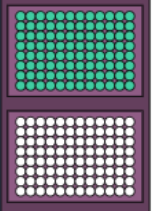

#### A Simple Tip Operation

You can have the liquid handler pick up a tip by calling `lh.pick_up_tips()`, and passing in the `TipSpot`s of the tips you want to retrieve.

`TipSpot`s are indexed the same way that wells are.

Let's try it

In [ ]:
# pick up a tip from spot A1 on the tip rack, using the first channel
await lh.pick_up_tips(tip_spots = tips_1000_uL_0["A1"],
                use_channels = [0])

IF you see an output like the one below, the liquid hanlder has picked up a tip!

```txt
Picking up tips:
pip#  resource             offset           tip type     max volume (µL)  fitting depth (mm)   tip length (mm)  filter    
  p0: 1000_tips_0_tipspot_0_0 0,0,0            HamiltonTip  1065             8                    95.1             Yes       
```

You should also see **spot A1** on the visualizer is now missing a tip. Let's go ahead and tell the liquid handler to return the tip.

In [ ]:
# return tips to their original locations
await lh.return_tips()

IF you see an output like the one below, the liquid hanlder has returned the tip.

```txt
Dropping tips:
pip#  resource             offset           tip type     max volume (µL)  fitting depth (mm)   tip length (mm)  filter    
  p0: 1000_tips_0_tipspot_0_0 0,0,0            HamiltonTip  1065             8                    95.1             Yes       
```

You can also **explicitly** tell the liquid handler where to drop tips, if a differnet location than where they were picked up from.

In [ ]:
# same pick up tips operation as before.
await lh.pick_up_tips(tip_spots = tips_1000_uL_0["A1"],
                use_channels = [0])

# explicitly tell liquid handler where to move tips to (useful if moving form one tip rack to another.)
await lh.drop_tips(tip_spots = tips_1000_uL_0["A1"],
                use_channels = [0])

This is a simple example of how to pick up, then return a tip. Let's investigate several different ways we can pick up tips.

#### Getting Information on Tip Status

PyLabRobot can  track whether or not the liquid handler has a tip, based on the history of executed steps on the liquid handler.

Let's check to see if the liquid handler has a tip on channel 0.

In [ ]:
# lh tip state
print(lh.head[0].has_tip)

`False` indicates that channel 0 does not have a tip. Let's pick one up and run the code again

In [ ]:
await lh.pick_up_tips(tip_spots = tips_1000_uL_0["A1"],
                use_channels = [0])
print(lh.head[0].has_tip)

Now it indicates `True`, indicating a tip is present. This can be useful for preventing operations when a tip isn't present.

We used the `[0]` syntax because we are asking if a the first channel has a tip on it on the given liquid handler. To see the full status of the head of the liquid handler, we can print `lh.head`

In [ ]:
print(lh.head)

This is a bit hard to read, let's write a function to print the liquid handller status neatly.

In [ ]:
def print_channels_tip_origin(lh):

    # Prints the origin location of all tips currently on the robot
    cur_pipetter = lh.head
    print("\nChannel Status...\n\n")

    for channel in cur_pipetter:
        print(f"Channel {channel}:")
        tip_tracker = lh.head[channel]
        if tip_tracker.has_tip == True:
            print(f"Tip: {tip_tracker.get_tip()}")
            print(f"Origin: {tip_tracker.get_tip_origin()}")
        else:
            print("No tip present.")
        print()

print_channels_tip_origin(lh)

Great! Now what you should notice is that channel 0 now contains both:

- A tip: `HamiltonTip(HIGH_VOLUME, has_filter=True, maximal_volume=1065, fitting_depth=8, total_tip_length=95.1, pickup_method=OUT_OF_RACK)`

- The tip's origin: `TipSpot(name=1000_tips_0_tipspot_0_0, location=Coordinate(007.200, 068.300, -83.500), size_x=9.0, size_y=9.0, size_z=0, category=tip_spot)`

This can be useful to gauge the status of the liquid handler head at any point in time

#### Picking Up, Returning, and Discarding Tips

So far, we have only shown how to get one tip at a time. For robots with only **one channel**, this is all you are limited to, and pipetting operations must be singleton (i.e. meaning, you would have to iterate over wells for pipetting with a **for loop**)

For coding purposes, this won't make much of a difference, since **for loops** can execute as fast as your machine can process the Pythonic code. However, if your particular liquid handler can grab **multiple tips** at the same time, then the number of **physical operations** (movement of the robotic arm) decreases signficantly, which can not only speed up your protocol, but also had other benefits such as energy cost savings and reduced wear-and-tear on the physical system.

The `use_channels` argument is very useful here, where you want to pass in a list of **channel indices** that you'd like to use to pick up the tips.

Let's see what happens when we use **two channels**

In [ ]:
# pick up tips with 2 channels
await reset_tip_box_and_pipette_head(lh, tips_1000_uL_0)
await lh.pick_up_tips(tip_spots = tips_1000_uL_0["A1", "A2"],
                use_channels = [0, 1])
print_channels_tip_origin(lh)

Great As we can see, we have picked up **two tips**, with one on each channel.

Let's try again with **all 8 channels**

In [ ]:
# using all 8 channels
await reset_tip_box_and_pipette_head(lh, tips_1000_uL_0)
tip_spots = [f"A{i + 1}" for i in range(8)] # this time, we enumerate all the tip spots
channels = [i for i in range(8)]
await lh.pick_up_tips(tip_spots = tips_1000_uL_0[tip_spots],
                use_channels = channels)
print_channels_tip_origin(lh)

Notice how we had to list out all the tip spots? This can get cumbersome.

Instead, we can provide a list of format `[Start_Well:End_Well]`

Let's pick up **8 tips again** using this method

In [ ]:
# using all 8 channels
await reset_tip_box_and_pipette_head(lh, tips_1000_uL_0)
channels = [i for i in range(8)]
await lh.pick_up_tips(tip_spots = tips_1000_uL_0["A1:A8"],
                use_channels = channels)
print_channels_tip_origin(lh)

You can also use the same `traverse()` function to iterate over the spots in a tip rack as well.

**Experiment** with the function below and use the visualizer to see the result of the tip rack after iterating through the **tip spots**, picking up the tips, then discarding them in the trash.

The function is written so that it uses the exact number of channels for the tips in a batch. See what happens if you increase the **batch size** to 8.

In [ ]:
tip_rack = tips_1000_uL_0

# EXPERIMENT HERE - MAKE CHANGES TO THE PARAMETERS AND SEE WHAT HAPPENS
tip_spots = tip_rack.traverse(start="top_left", batch_size = 4, direction='down')

async def print_tip_batches(tip_spot_iterator):
    await reset_tip_box_and_pipette_head(lh, tips_1000_uL_0)
    for i, tip_spots in enumerate(tip_spot_iterator):
        channels = [j for j in range(len(tip_spots))]
        if i % 2 == 0:
            await lh.pick_up_tips(tip_spots = tip_spots,
                        use_channels = channels)
            await lh.discard_tips()

await print_tip_batches(tip_spots)

Note that some liquid handlers have more than **8 channels**. Some even have a 96-channel head, which can pick up entire plats of wells at one time.

Using this requires special functions shown below. Let's first pick up 96 tips.

Since you are picking up the entire tip box, there is **no need to specify tip spots**

In [ ]:
await reset_tip_box_and_pipette_head(lh, tips_1000_uL_0, mode = "96")
await lh.pick_up_tips96(tips_1000_uL_0)

# now switch to the visualizer and see what happened

Return the tips using `return_tips96()`

In [ ]:
await lh.return_tips96(tips_1000_uL_0)

# now switch to the visualizer and see what happened

PLR also has functionality to **iterate** over all possible tip boxes.

Normally, if you run out of tips in a tip box, you will need to **tell PLR to proceed to the next tip box** but using the following iterators enable traversing and picking up tips across **several tip boxes** across the entire deck.

Right now, there are two iterators:

- A **random** iterator

- A **linear** iterator

These can be imported from the `pylabrobot.resources.functional` library.

In [ ]:
import pylabrobot.resources.functional as F

Now, add **all the tip racks you care about** to one **list** for use in the iterator.

You can also create separate generators for different tip sizes!

In [ ]:
tip_racks = [tips_1000_uL_0, tips_1000_uL_1]

Now, using `F.get_all_tip_spots()`, get an iterable list of tip spots

In [ ]:
tip_spots = F.get_all_tip_spots(tip_racks)

Create the generator

In [ ]:
linear_generator = F.linear_tip_spot_generator(
  tip_spots=tip_spots,                      # the list of tip spots to use
  repeat=False,                             # don't repeat the tip spots if they run out
)

Finally, we can iterate over the generator.

Normally in python this is done with a `for` loop; however, these generators are **asynchronous**, meaning you need to iterate over them with the `async for` prefix or the `anext()` functions in Python.

Let's show using a for loop to iterate 3 times.

In [ ]:
i = 0
async for tip in linear_generator:
    if i > 2:
        break
    print(tip)
    i += 1

The `anext` command is useful to get a list of items from an asynchornous generator

In [ ]:
tip_list = [await anext(linear_generator) for _ in range(3)]
print(tip_list)

You can also **randomly** iterate over tip spots using the random generator. Let's make one using the same tip spots.

In [ ]:
random_generator = F.randomized_tip_spot_generator(
  tip_spots=tip_spots,                      # the list of tip spots to use
  K=192,                                     # don't sample tip spots that have been used in the last K samples.
)

# If K is less than the number of tip spots you are sampling, you can accidentally sample a tip spot that does not have a tip.

Now, let's randomly iterate and pick up **40 tips** and see what it looks like on our visualizer.

You should explore different parameter options to test here and visualize the effects!

In [ ]:
# reset both tip boxes since we are iterating over all of them.
await reset_tip_box_and_pipette_head(lh, tips_1000_uL_0)
await reset_tip_box_and_pipette_head(lh, tips_1000_uL_1)

# initialize counters
max_tips = 90 # CHANGE THIS TO SEE WHAT HAPPENS
curr_tip = 0

# sample tips randomly
async for tip in random_generator:
    await lh.pick_up_tips(tip_spots=[tip], use_channels=[0])
    await lh.discard_tips()
    curr_tip += 1
    if curr_tip >= max_tips:
        break

These are most of the ways to iterate over tips in PLR. With this knowledge you are ready to handle some liquids!

#### Tip-Related Errors

There are several errors that can occur when picking up or dropping tips in PLR.

Let's pick up a tip.

In [ ]:
# reset tip deck
await reset_tip_box_and_pipette_head(lh, tips_1000_uL_0)
await reset_tip_box_and_pipette_head(lh, tips_1000_uL_1)

# error: return tips - explanation
await lh.pick_up_tips(tip_spots=tips_1000_uL_0["A1"], use_channels=[0])

What do you think will happen when we try to pick up a tip again?

Let's try it.

In [ ]:
# error: return tips - explanation
await lh.pick_up_tips(tip_spots=tips_1000_uL_0["A2"], use_channels=[0])

You should see an error that says:

 **HasTipError:** Channel has tip.

 This means the channel already has a tip on it, so let's go ahead and discard the tip first.

In [ ]:
await lh.discard_tips()

Now, let's see what happens when we try to pick up a tip from **well A1**, which is missing a tip since we just discarded it.

In [ ]:
await lh.pick_up_tips(tip_spots=tips_1000_uL_0["A1"], use_channels=[0])

Now we get a different error:

**NoTipError:** Tip spot does not have a tip.

This makes sense since the tip spot does not have a tip available, so we should've grabbed one from **A2**

In [ ]:
await lh.pick_up_tips(tip_spots=tips_1000_uL_0["A2"], use_channels=[0])

Now discard it

In [ ]:
await lh.discard_tips()

What if we try to discard the tip again?

In [ ]:
await lh.discard_tips()

We get a **RuntimeError:** No tips have been picked up and no channels were specified.

A similar error occurs if we attempt to return or drop tips with an empty liquid handler head.

In [ ]:
await lh.return_tips()

These are the most likely errors you will encounter as you develop your protocol.

By catching these errors **in silico** you can help **reduce** the number of criticial errors occuring when running the robot in a high-stake experiment!

### Liquid Handling - Aspiration and Dispensing
Now that you have learned the basics of traversing lab equipment and moving tips, we can cover the basics of moving liquids.

Moving a liquid consists of two steps:

- **Aspiration:** or drawing up liquid into the tips on the liquid handler.

- **Dispensing:** or ejecting the liquid into a destination.

Both these steps are **almost identical** to the utilities for picking up and moving tips.

First, we will show you a basic transfer using one tip from one well to another.

Then we will show you a few other transfer methods, using multiple-channels and a 96-channel head

Finally, we will cover some of the unique errors you can encounter, including PLR's ability to track cross-contamination

#### Simple Liquid Transfer Example

First, let's set up the deck

In [ ]:
async def setup_liquid_transfer_deck():
    deck = await make_liquid_handling_deck()
    lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

    # get tip boxes of interest
    tips_1000_uL = lh.deck.get_resource("1000_tips_1")
    tips_300_uL = lh.deck.get_resource("300_tips_1")

    # get plates of interest
    plate_0 = lh.deck.get_resource("12_plate_0")
    plate_1 = lh.deck.get_resource("96_plate_0")
    plate_2 = lh.deck.get_resource("96_plate_1")
    return deck, lh, tips_1000_uL, tips_300_uL, plate_0, plate_1, plate_2

Get the resources of interest


In [ ]:
# get tip boxes of interest
deck, lh, tips_1000_uL, tips_300_uL, plate_0, plate_1, plate_2 = await setup_liquid_transfer_deck()

Go ahead and set the intial liquids.

In [ ]:
# let's go ahead and create a liquid called red dye and octanol
# let's go ahead and start with 6000 uL = 6 platesmL of each liquid
# let's simulate us starting with this liquid in plate 0 (12-well plate)
def set_starting_liquids():
    red_dye = ("Red Dye", 6000)
    octanol = (Liquid.OCTANOL, 6000)
    # assign red dye to well A1
    plate_0.get_well("A1").tracker.set_liquids([red_dye])
    # assign octanol to well A2
    plate_0.get_well("A2").tracker.set_liquids([octanol])

Now, let's go ahead and move 200 uL of red dye to well A1 of plate_1

In [ ]:
# reset deck
await reset_tip_box_and_pipette_head(lh, tips_300_uL)
set_starting_liquids()

# first pick up one 300 uL tip
await lh.pick_up_tips(tip_spots = tips_300_uL["A1"], use_channels=[0])

# next, aspirate 200 uL of red dye from well A1 on plate_0
await lh.aspirate(plate_0["A1"], vols = [200])

# then, move the robot to plate_1 and dispense the liquid
await lh.dispense(plate_1["A1"], vols = [200])

# finally, discard the tips on the liquid handler
await lh.discard_tips()

#### Other Liquid Handling Examples

We can, of course, transfer liquid one well at at time in a for loop.

Let's go ahead and pipette **200 uL** into the **first column** of **plate 1**

In [ ]:
# reset deck
await reset_tip_box_and_pipette_head(lh, tips_300_uL)
reset_liquids(plate_1)
set_starting_liquids()

# char alphabet
alphabet = [chr(i) for i in range(65, 73)]

# for each well in first column
for i in range(8):
    await lh.pick_up_tips(tip_spots = tips_300_uL[f"{alphabet[i]}1"], use_channels=[0])

    # next, aspirate 200 uL of red dye from well A1 on plate_0
    await lh.aspirate(plate_0["A1"], vols = [200])

    # then, move the robot to plate_1 and dispense the liquid
    await lh.dispense(plate_1[f"{alphabet[i]}1"], vols = [200])

    # finally, discard the tips on the liquid handler
    await lh.discard_tips()

This is a bit clunky though. Let's make use of our **8 channel** pipette head and some more compact notation!

Let's go ahead and pipette **200 uL** from the **first column** of **plate 1** to the **second column** of **plate 1**

In [ ]:
# set channels to use
channels_to_use = [i for i in range(8)]

# pick up tips from second column since we already used the first column
await lh.pick_up_tips(tip_spots = tips_300_uL["A2:H2"], use_channels=channels_to_use)

# aspirate first column of liquid
await lh.aspirate(plate_1["A1:H1"], vols = [200] * 8)

# dispense first column of liquid to second column
await lh.dispense(plate_1["A2:H2"], vols = [200] * 8)

# discard tips
await lh.discard_tips()

This still seems a bit cumbersome. Let's take advantage of Python **functions** to write a function which will take a column to pipette from, a column to pipette to, a volume, and a tip rack and will **automaticallly pipette a column from one location to another**

In [ ]:
from pylabrobot.resources import TipRack, Plate

async def pipette_col(input_col: int,
                      input_plate: Plate,
                      target_col: int,
                      target_plate: Plate,
                      tip_rack_resource: TipRack,
                      volumes: list[float]):

    alphabet = [chr(i) for i in range(65, 73)]

    # get number of channels to use based on length of volumes
    n = len(volumes)
    channels_to_use = [i for i in range(n)]
    col_input_idx = f"A{input_col}:{alphabet[n - 1]}{input_col}"
    col_tgt_idx = f"A{target_col}:{alphabet[n - 1]}{target_col}"

    # pick up tips from second column since we already used the first column
    await lh.pick_up_tips(tip_spots = tip_rack_resource[col_tgt_idx], use_channels=channels_to_use)

    # aspirate first column of liquid
    await lh.aspirate(input_plate[col_input_idx], vols = volumes)

    # dispense first column of liquid to second column
    await lh.dispense(target_plate[col_tgt_idx], vols = volumes)

    # discard tips
    await lh.discard_tips()

Now let's use this function to move the **2nd column** to the **3rd column**

In [ ]:
await pipette_col(input_col = 2,
                  input_plate = plate_1,
                  target_col = 3,
                  target_plate = plate_1,
                  tip_rack_resource = tips_300_uL,
                  volumes = [200] * 8)

With functions, we can **drastically reduce** the amount of code we use!

Now, let's use our function above to pipette a **gradient of liquid amounts** from **column 3** to **column 4**.

Instead of using a list of constant volume amounts `[200] * 8`, we instead use a `range()` of 25 uL increments from 0 to 175 uL as follows: `[i for i in range(0, 200, 25)]`

In [ ]:
await pipette_col(input_col = 3,
                  input_plate = plate_1,
                  target_col = 4,
                  target_plate = plate_1,
                  tip_rack_resource = tips_300_uL,
                  volumes = [i for i in range(0, 200, 25)])

Now go look at the visualizer and see the color gradients we created!

Implementing this with a for loop would've taken **a lot more code**. This shows the power of **functionalizing your code**

#### Liquid Handling Errors

Trackers in PyLabRobot are objects that keep track of the state of the deck throughout a protocol. Three types of trackers currently exist:

- **tip trackers** - tracks the presence of tips in tip racks and on the pipetting channels
- **volume trackers** - tracks the volume in pipetting tips and wells/reservoirs
- **cross contamination** - tracks whether a given action would result in two liquids mixing unintentionally, thus introducing contamination in a sample or tip.

To **enable these**, you must explicitly call

```python
# enable tracking of tip status and volumes
set_volume_tracking(enabled=True)
set_tip_tracking(enabled=True)
```

We have already seen the errors that the **tip tracker** can throw. But now let's go ahead and explore various errors you could run into when performing liquid handling exercises. First, let's reset the deck.

In [ ]:
await reset_tip_box_and_pipette_head(lh, tips_300_uL)
reset_liquids(plate_1)
set_starting_liquids()

The first error you can get is when you attempt to dispense **more liquid** than currently held in the liquid handler head.

This results in a `TooLittleLiquidError`

In [ ]:
from pylabrobot.resources.volume_tracker import TooLittleLiquidError, TooLittleVolumeError

try:
  await lh.pick_up_tips(tip_spots = tips_300_uL["A1"])
  await lh.dispense(plate_1["A1"], vols=[100]) # this is less liquid than is currently in the tip
except TooLittleLiquidError as e:
  print("As expected:", e)

If you try to aspirate from a container that does not have enough of the requested volume, you can run into a `TooLittleVolumeError`

Let's demmonstrate this now

In [ ]:
# reset head
lh.clear_head_state()
reset_liquids(plate_1)

# fill the first two columns of the plate with 200 uL water
for i in range(16):
  plate_1.get_item(i).tracker.set_liquids([(Liquid.WATER, 200)])

try:
  for i in range(16):
    await lh.aspirate(plate_1[i], vols=[200])
except TooLittleVolumeError as e:
  print("As expected:", e)

Similarly, we could also get an error if we try to **aspirate too much volume** from a given well.

For example, let's see what happens if we try to aspirate **360 uL** from a well with only **200 uL**

In [ ]:
# reset head
lh.clear_head_state()

# fill the first two columns of the plate with 200 uL water
for i in range(16):
  plate_1.get_item(i).tracker.set_liquids([(Liquid.WATER, 200)])
try:
  await lh.aspirate(plate_1["A1"], vols=[360]) # the second aspiration will attempt to grab 200 uL, but the tip can only hold 360 uL volume total!
except TooLittleLiquidError as e:
  print("As expected:", e)

Finallly, we could also try to **dispense too much volume** into a given well.

Let's see what happens if we try to aspirate **1 mL** of Octanol and dispense all of it into a **360 uL** well of a plate.

In [ ]:
# reset head
lh.clear_head_state()
await reset_tip_box_and_pipette_head(lh, tips_1000_uL)
reset_liquids(plate_1)

try:
  await lh.pick_up_tips(tips_1000_uL["A1"])
  await lh.aspirate(plate_0["A1"], vols=[1000])
  await lh.dispense(plate_1["A1"], vols=[1000])
except TooLittleVolumeError as e:
  print("As expected:", e)

#### Cross Contamination

Uniquely, PLR can also track cross-contamination.

Cross contamination can be defined as the unintentional transfer of contaminants (like substances, microorganisms, or foreign particles) from one source to another, compromising the integrity of a sample or experiment.

In code, this simply tracks the liquids in a given tip

In [ ]:
import time

# enable cross contamination tracking
from pylabrobot.resources import (
    set_cross_contamination_tracking
)
set_cross_contamination_tracking(enabled=True)

# fully reset deck
deck, lh, tips_1000_uL, tips_300_uL, plate_0, plate_1, plate_2 = await setup_liquid_transfer_deck()
set_starting_liquids()

# aspirate 200 uL of dye from well A1 on plate 0
await lh.pick_up_tips(tips_300_uL["A1"])
time.sleep(1)
await lh.aspirate(plate_0["A1"], vols=[200])
time.sleep(1)
await lh.dispense(plate_1["A1"], vols=[200])
time.sleep(1)

# instead of discarding, let's return the tips to re-use
await lh.return_tips()

# now let's use the same tip and aspirate 200 uL of octanol from well B1 on plate 0
await lh.pick_up_tips(tips_300_uL["A1"])
time.sleep(1)
await lh.aspirate(plate_0["A2"], vols=[200])
time.sleep(1)
await lh.dispense(plate_1["A2"], vols=[200])
time.sleep(1)

You should have gotten an error showing that you **are trying to aspirate Octanol with a tip contaminated with **Red Dye**

```txt
CrossContaminationError: Attempting to aspirate Liquid.OCTANOL with a tip contaminated with {'Red Dye'}.
```

If needed, you can also disable the cross contamination check with the `no_cross_contamination_tracking` context manager. Let's show the same exact code. This time, no error will be thrown because we have overriden the cross contamination tracking.

In [ ]:
from pylabrobot.resources import (
    no_cross_contamination_tracking
)

# fully reset deck
deck, lh, tips_1000_uL, tips_300_uL, plate_0, plate_1, plate_2 = await setup_liquid_transfer_deck()
set_starting_liquids()

# aspirate 100 uL of dye from well A1 on plate 0
await lh.pick_up_tips(tips_300_uL["A1"])
time.sleep(1)
await lh.aspirate(plate_0["A1"], vols=[100])
time.sleep(1)
await lh.dispense(plate_1["A1"], vols=[100])
time.sleep(1)
await lh.return_tips()

# by using the context manager, we can override the cross contamination tracking, but this should be
# used VERY CAREFULLY.
with no_cross_contamination_tracking():
    await lh.pick_up_tips(tips_300_uL["A1"])
    time.sleep(1)
    await lh.aspirate(plate_0["A2"], vols=[100])
    time.sleep(1)
    await lh.dispense(plate_1["A1"], vols=[100])


The basic way cross contamination check works is as follows:

Assume we have a set of liquids that have been present in a given tip, denoted as $\{T_i\}$

Assume we also have a set of liquids that have been present in a given well, denoted as $\{W_i\}$

The cross contamination check is simply checking if the **tip history** is a **subset** of the **well history**. If it is not, then cross contamination will occur.

This is defined as $\text{CC} = \{T_i\} \not\subset \{W_i\}$

### Exercises

---

**TO-DO:** For each of the following exercises, set up the deck within the `deck_exercise_N()` block of code and set up the liquid handling protocol within the `run_protocol_exercise_N()` block of code.

Some exercises below will ask you to define your own **functions**. We will provide the **function name** and **input argument names** for you, but in gneeral, the body of the functions is up to you.

You should include `time.sleep(x)` calls between every pipetting step so you have time to visualize the protocol as it runs. At a minimum, `x = 0.1` for 0.1 s delay. Experiment with this value for one that works for you.

Once you get your protocol working as intended for each problem, you will need to **record a GIF** of your protocol running for each exercise.

In the Workshop 2 Canvas assignment, submit for each exercise the following:

1. `deck_layout_exercise_N.gif` - a GIF recording of your protocol in action

2. `exercise_N.txt` text file containing the code that runs the protocol


**IMPORTANT** - You should be judiciously commenting your code to explain its function. We will grade every problem by **quality of code**. Excessively long code or lack of comments will be subject to **point deduction**

---

**Some Helpful Tips**

- Use consistent naming for deck items in your deck setup functions. You should **retrieve relevant items** using `get_item` in the **protocol functions**.

- Almost everything you will be asked to do has been covered in code above.

- When writing your functions, set up a test deck by creating a new code cell and running the function on a simple test case before trying to run the entire protocol.

- Include a `time.sleep()` call between every pipette step to help visualize the operations.

- Include a longer `time.sleep()` call between the setup deck function and protocol function. Switch to the visualizer in this time and start recording your GIF to visualize the protocol.


As always, if you find yourself needing assistance, reach out on the \#Ed-Discuss channel on slack.

---

1. Basic Liquid Handling (**20 pts**)

    - Set up a Hamilton STAR Deck with

        - 1x 12x15 mL Reservoir

        - 1x 96-well 2 mL deep plate

        - 1x box 300 uL tips
        
        - 1x box 1000 uL tips

    - Add 2 mL each of 4 dyes called "Dye_N" to the 12 x 15 mL reservoir:

        - 2 mL of Dye 1 to well A1

        - 2 mL of Dye 2 to well A2
        
        - 2 mL of Dye 3 to well A3

        - 2 mL of Dye 4 to well A4

    - Write a liquid handling protocol that executes the steps below in order:

        - Add 100 uL of Dye_1 to well A1.

        - Add 200 uL of Dye_2 to well B7.

        - Add 50 uL of Dye_1 and 50 uL of Dye_3 to well C9.

        - Add 25 uL of Dye 1, 25 uL of Dye 2, 25 uL of Dye 3, and 25 uL of Dye 4 to well D12.

        - Add 50 uL of Dye 1 and 50 uL of the solution in D12 to well A3.

        - Add 1800 uL of Dye 1 to well F12. (**hint**: add all remaining volume from your reservoir + somewhere else on the plate)

In [ ]:
from pylabrobot.resources import (
    # YOUR CODE HERE
)

async def deck_exercise_1():
    deck = ... # YOUR CODE HERE
    return deck

async def run_protocol_exercise_1(deck, lh):
    ... # YOUR CODE HERE

deck = await deck_exercise_1()
lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

# delay 3 seconds to give time to switch to visualizer
time.sleep(3)

await run_protocol_exercise_1(deck, lh)

2. Mixing Colors (**40 pts**)

    - We will be making a color rainbow on a 96-well plate

    - Remember a rainbow is considered as R-O-Y-G-B-V in our case:

        - R - Red

        - O - Orange = (equal parts Red + Yellow)

        - Y - Yellow

        - G - Green = (equal parts Yellow + Blue)

        - B - Blue

        - V - Violet = (equal parts Blue + Red)

    - Set up a Hamilton STAR Deck with

        - 1x 12x15 mL Reservoir

        - 1x 96-well 360 uL plate

        - 1x box 300 uL tips

    - Add 10 mL of dyes to the reservoir:

        - 10 mL of "Red Dye" to well A1

        - 10 mL of "Yellow Dye" to well A2

        - 10 mL of "Blue Dye" to well A3

    - Write a liquid handling protocol that:

        - Pipettes 300 uL of each color dye to the column it should go in the rainbow using **one channel**

            - Red -> Column 1

            - Yellow -> Column 3

            - Blue -> Column 5

        - Uses a function `pipette_col_exercise_2` to pipette 100 uL of color A from column X and 100 uL of color B from column Y into column Z using **all 8 channels**

            - Orange -> Column 2

            - Green -> Column 4

            - Purple -> Column 6

        - Uses a function `mix_col_exercise_2` to mix the colors together in each column by aspirating up and down

---

**Function Hints**

- `pipette_col_exercise_2`
    - You should first **aspirate** using **8 channels** from **column a** on the **plate**

    - You should then **dispense** into **column c** and **discard tips**

    - You should then **aspirate** using **8 channels** from **column b** on the **plate**

    - You should then **dispense** into **column c** and **mix** the contents and then **discard tips**

        - This will involve invoking the `mix_col_exercise_2` function

    - The `index` should be an **integer** representing the column to aspirate from (1 = first column)

    - The `vols` argument should be a **list of floats** that contain the volumns you are pipetting from each row (this should be constant)

- `mix_col_exercise_2`

    - Assume you have tips already on the liquid handler head.

    - You should then **aspirate** using **8 channels** from **wells** on the **plate**

    - You should then implement a **0.5s delay**

    - You should then **dispense** using **8 channels** into **wells** on the **plate**

    - You should repeat this mixing `n_mixes` number of times

    - You should **discard tips** outside of this function (i.e. in `pipette_col_exercise_2`)

---

In [ ]:
from pylabrobot.resources import (
    # YOUR CODE HERE
)

async def deck_exercise_2():
    deck = ... # YOUR CODE HERE
    return deck

async def mix_col_exercise_2(
        lh, # the liquid handler pointer
        plate, # plate to mix on
        wells, # wells on the plate to mix in
        n_mixes, # number of mixes
        vols # volume to mix. should be ~0.8x the total volume in the plate wells
):
    ... # YOUR CODE HERE

async def pipette_col_exercise_2(
        lh, # the liquid handler pointer
        plate, # the plate to pipette on
        tip_rack, # the tip rack to use
        tip_rack_indexes, # the tip spots to use
        col_a_index, # character "A", "B", etc. representing the column to pipette first dye from
        col_b_index, # character "A", "B", etc. representing the column to pipette second dye from
        mix_col_index, # character "A", "B", etc. representing the column to mix dyes in to make new color
        vols # volume to pipette
):
    assert len(tip_rack_indexes) == 2, f"tip_rack indexes must only be two columns in total. Got {tip_rack_indexes}"
    ... # YOUR CODE HERE


    # example of calling the mix call script
    # await mix_col_exercise_2(lh = lh,
    #                          plate = plate,
    #                          wells = col_mix_indexes,
    #                          n_mixes = 5,
    #                          vols = vols)
    # await lh.discard_tips()

async def run_protocol_exercise_2(deck, lh):


    ... # YOUR CODE HERE
    # example of calling the pipette col script
    # for ... in ...
    #     await pipette_col_exercise_2(
    #         lh = lh,
    #         plate = ...,
    #         tip_rack = ...,
    #         tip_rack_indexes = ...,
    #         col_a_index = ...,
    #         col_b_index = ...,
    #         mix_col_index = ...,
    #         vols = [100] * 8
    #     )

deck = await deck_exercise_2()
lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

# delay 3 seconds to give time to switch to visualizer
time.sleep(3)

await run_protocol_exercise_2(deck, lh)


3. Serial Dilutions (**40 pts**)

    - Remember the deck you setup from **workshop 1?** You will be setting up a similar deck this time but actually doing the serial dilutions.

    - You will start with stock solutions of 100 mL each of 1M red, blue, and yellow dye.

    - You will be doing 12 serial dilutions (11 total dilutions + 1 stock concentration = 12 total concentrations) of each color, in triplicate.

        - These dilutions will be 1:7, meaning you should:

            - Pipette **420 uL** of stock solution (1 M) into each of 3 starting wells on a plate you choose

                - Use 3x1000 uL tips for this (triplicate)

            - Pipette **60 uL** of the previous concentration (in this case, 1M "starting wells") to the next set of 3 wells.

                - Use 3x300 uL tips for this (triplicate)

            - Pipette **420 uL uL** of **diluent** (water) into the wells with **50 uL** and **mix**

                - Use 3x1000 uL tips for this (triplicate)

            - Repeat the latter two steps for each concentration until you get 12 different concentrations in total.

        - Becuase you are doing serial dilutions in triplicate, you should use **3 channels** on the pipette head during operation.

        - You should have your **red dye** dilutions in the top 3 A, B, C rows of the **first plate**

        - You should have your **blue dye** dilutions in the  E, F, G rows of the **first plate**

        - You should have your **yellow dye** dilutions in the top 3 rows A, B, C of the **first plate**

        - You should complete all **helper functions** as outlined below, for pipetting

        - You should also use a **linear tip generator** to iterate over available tips on your deck. Create these in the relevant **function**

        - You should implement the logic to **print** the concentration of each well and also add it as a **comment** in the code below.

        - You should calculate and add **1.2x** the diluent you need for the entire experiment and add to the initial diluent reservoir.


    - Set up an OpenTrons (OT2) Deck with

        - 4x mL Reservoir with capacity for 100 mL

        - 2x 96-deep-well plates

        - 2x box 1000 uL tips

        - 2x box 300 uL tips

        - They should be arranged from most -> least sterile

    - Add 100 mL of dyes to the reservoir:

        - 100 mL of "Red Dye" to reservoir 1

        - 100 mL of "Yellow Dye" to reservoir 2

        - 100 mL of "Blue Dye" to reservoir 3

    - Calculate how much **diluent you need** and add **1.2x** that amount. We will check the correctness of this value. Add this as a comment ot your code

    - Write a liquid handling protocol that achieves the serial dilution by:

        - Pipetting **480 uL** of each dye to the corresponding first 3 rows for each serial dilution.

            - You should call `initial_col_pipette_exercise_3` for each dye and target plate

        - Create a iterator using the `F.linear_tip_spot_generator`to iterate over the available tips in batches of 3.

            - Implement this in the `prepare_generators_exercise_3` function and call in the main protocol

            - Remember you will need **separate tips** for pipetting from the prior concentration and pipetting from the diluent. This menans you may need **at least two separate generators (up to four depending on how you approach it)**.

        - Using the `pipette_triplicate_dilutions_exercise_3` function to input the corresponding row identifiers and perform a serial dilution in triplicate.

            - This should call the  `mix_col_exercise_3` function within it to mix.

    - In a **comment** in youc code, list the final concentrations of each of the serial diliutions

        - The formula $C_1 V_1 = C_2 V_2$ may be helpful for calculating this

        - This should be computed in the `pipette_triplicate_dilutions_exercise_3` function.

---

**Function Hints**

- `pipette_triplicate_dilutions_exercise_3`

    - Should be called **once per color**

    - Should iterate over a **for loop** for number of dilutions

    - Should pipette **column-wise** in **triplicate**

    - At each **dilution**

        - Get the **tip spots next in the generator for both tip types**

            - These are **asynchronous generators**, so to get N items from a generator named `gen`, this code may be useful:

                ```python
                    items_selected = [await anext(gen) for _ in range(N)]
                ```

        - Pick up appropriate tips, aspirate from the prior column to the new column the **transfer_vol**

        - Discard tips

        - Pick up appropriate tips, aspirate **dilution volume*** from the diluent reservoir, and dispense to the same column.

        - Call the `mix_col_exercise_3` function to mix the dilution.

        - Discard tips

        - Using the **starting_conc**, calculate the **new concentration** using the volume variables and append to the `conc_report` to print the concentrations in **each well**

- `initial_col_pipette_exercise_3`

    - Should be called **once per dye**

    - Should pick up tips **from the bottom right side of the tip box to not disrupt the generators**

    - Should pipette the **starting volume of dye** from the **relevant dye container** and dispense in the relevant **first column** of the **relevant plate**

    - Should discard tips afterwards.

    - May use either **1 tip** or **3 tips** with **1 channel** or **3 channels** (both are acceptable)

- `prepare_generators_exercise_3`

    - Should input a **list of tip racks** for both the **1000 uL tip racks** and **300 uL tip racks**

    - Should get **all tip spots** twice (once for 1000 uL and once for 300 uL)

    - Should create a **linear generator** for **each tip size** by taking the **tip spots**

    - Should return the **generator objects**

- `mix_col_exercise_3`

    - Should be identical to **exercise 2** except this time mix for **3 times** and **0.75 seconds each**

---

In [ ]:
from pylabrobot.resources.opentrons import ... # need to import new OpenTrons Deck Layout
from pylabrobot.resources import (
    ... # YOUR CODE HERE
)

async def deck_exercise_3():
    deck = ... # YOUR CODE HERE
    return deck

async def pipette_triplicate_dilutions_exercise_3(
        lh,
        plate,
        diluent_reservoir,
        row_start_idx,
        row_end_idx,
        transfer_vol,
        dilution_vol,
        tip_generator_300,
        tip_generator_1000,
        num_dilutions,
        starting_conc = 1.0
):

    # list to append concentration reports
    conc_report = []

    # for each dilution
    for i in range(num_dilutions):
    
        # example code to get tip spots
        tips_300_spots = [await anext(...) ...] # YOUR CODE HERE
        tips_1000_spots = [await anext(...) ...]

        ... # YOUR CODE HERE
        # example of calling mix script
        # await mix_col_exercise_2(...)
        # await lh.discard_tips()

        # concentration calculation code
        new_conc = ... # YOUR CODE HERE
        start_text = f"Dilution {i + 1}: Start Conc: {starting_conc} M"
        end_text = f"End Conc: {new_conc} M"
        conc_report.append(f"{start_text:<55}{end_text}")
        starting_conc = new_conc
    return conc_report

async def initial_col_pipette_exercise_3(
                            reservoir,
                            target_plate_wells,
                            volume,
                            tip_spots):
    ... # YOUR CODE HERE

def prepare_generators_exercise_3(
        tip_racks_300,
        tip_racks_1000
):
    ... # YOUR CODE HERE
    linear_generator_300 = ... # YOUR CODE HERE
    linear_generator_1000 = ... # YOUR CODE HERE
    return linear_generator_300, linear_generator_1000

async def mix_col_exercise_3(
        lh,
        plate,
        wells,
        n_mixes,
        vols
):
    ... # YOUR CODE HERE

async def run_protocol_exercise_3(deck, lh):

    
    ... # YOUR CODE HERE

    await initial_col_pipette_exercise_3(
        reservoir = red_reservoir,
        ... # YOUR CODE HERE
    )
    await initial_col_pipette_exercise_3(
        reservoir = blue_reservoir,
        ... # YOUR CODE HERE
    )
    await initial_col_pipette_exercise_3(
        reservoir = yellow_reservoir,
        ... # YOUR CODE HERE
    )
    linear_generator_300, linear_generator_1000 = prepare_generators_exercise_3(
        ... # YOUR CODE HERE
    )

    conc_report = await pipette_triplicate_dilutions_exercise_3(
        ... # YOUR CODE HERE
    )
    for s in conc_report:
        print(s)
        # copy output of this to the comment below

deck = await deck_exercise_3()
lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

# delay 3 seconds to give time to switch to visualizer
time.sleep(3)
await run_protocol_exercise_3(deck, lh)

# --- Concentration Informations ---
# copy output here below and add comment prefix "#" to each line

---

#### Conclusion

That's all for workshop 2! Double check that you have submitted a `.gif` file and `.txt` file for each exercise **1-3** (6 files total)

If you are still feeling unsure on deck setup, please **reach out to the teaching team**, contact info for whom can be found in the .`README.md` file on the [class GitHub](https://github.com/chory-lab/bme590-fall-2025)

---